In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from glob import glob

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc
from joblib import load, dump
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel, loadmap
from aggmap import show
np.random.seed(666) #just for reaptable results


from tqdm import tqdm

tqdm.pandas(ascii=True)

In [2]:
def gauss_noisy(X, c = 0.38):
    ''' 
    X: 4D array, n,w,h,c
    '''
    np.random.seed(123)
    X = np.clip(X + np.random.normal(size = X.shape, scale = c), 0, 1)
    return X

In [3]:
flist = glob('./data/*.csv.gzip')
flist = pd.Series(flist).sort_values().tolist()
fall = []
for i in flist:
    df1 = pd.read_csv(i, compression='gzip', index_col = 0)
    df1['class'] = i.split('/')[-1].split('.csv')[0]
    fall.append(df1)
    
df = pd.concat(fall, axis=0)

In [4]:
dfx = df[df.columns[:-1]]
dfy = df[df.columns[-1:]]
dfx = np.log2(dfx + 1) #apply log2(x + 1)

In [6]:
data_save_folder = '/raid/shenwanxiang/transcriptome/pan-cancer'
if not os.path.exists(data_save_folder):
    os.makedirs(data_save_folder)


scale_method = 'minmax'
mp = loadmap('/raid/shenwanxiang/agg_mp_object/pan-cancer.mp')

if not os.path.exists(os.path.join(data_save_folder, 'Agg5.data')):
    # save multi-channel
    X = mp.batch_transform(dfx.values, scale_method = scale_method) 
    n, w, h, c = X.shape
    dump(X,  os.path.join(data_save_folder, 'Agg5.data')) 
    
    ## save single channel
    X1 = X.sum(axis=-1).reshape(n, w, h, 1)
    dump(X1,  os.path.join(data_save_folder, 'Agg1.data')) 

else:
    X = load(os.path.join(data_save_folder, 'Agg5.data'))
    
Y = pd.get_dummies(dfy['class']).values

In [16]:
stddevs = np.arange(0, 0.5, 0.08)

In [17]:
stddevs

array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 , 0.48])

In [ ]:
X_noisys_1 = []
X_noisys_5 = []

n, w, h, c = X.shape

for stddev in stddevs:
    X1 = X.sum(axis=-1)
    X1_n = gauss_noisy(X1, c = stddev)
    dfx1_n = X1_n.reshape(n, w*h)
    
    dfx1 = pd.DataFrame(dfx1_n, columns = mp.df_grid.sort_values(['y','x']).v, index = dfx.index)
    dfx1 = dfx1[mp.flist]
    dfx5 = dfx1.progress_apply(lambda x: mp._S.transform(x.values), axis=1)
    X5_n = np.stack(dfx5.tolist(),axis=0)
    
    X_noisys_5.append(X5_n)
    X_noisys_1.append(X1_n.reshape(n, w, h, 1))
    
dump(X_noisys_5,  os.path.join(data_save_folder, 'Agg5_noisys.data')) 
dump(X_noisys_1,  os.path.join(data_save_folder, 'Agg1_noisys.data')) 

100%|##########| 10446/10446 [00:30<00:00, 343.91it/s]


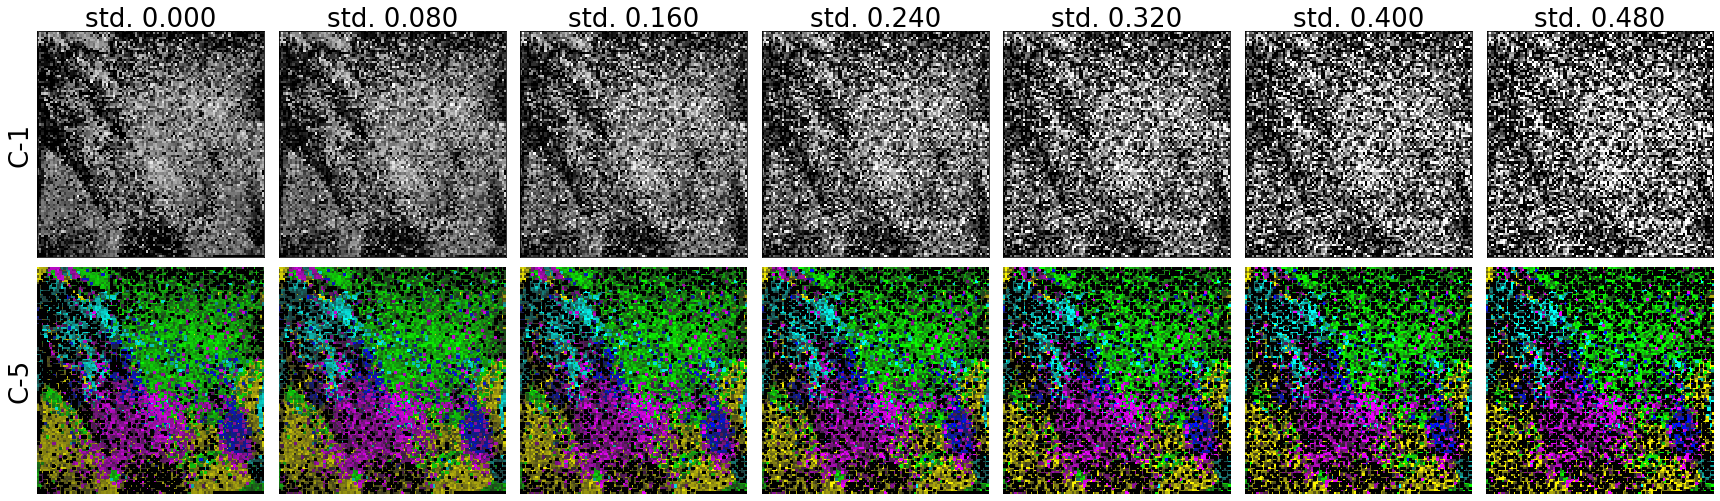

In [82]:
rows = ['std. %.3f' % i for i in stddevs]
fontsize = 26
fig, axes = plt.subplots(nrows=2, ncols=len(rows), figsize=(24, 7), sharex = False, sharey = False)


X1 = [X_noisys_1[i][0] for i in range(len(rows))]
X2 = [X_noisys_5[i][0] for i in range(len(rows))]
X1.extend(X2)

for x, ax in zip(X1, axes.ravel()):
    
    
    #ax.imshow(x.sum(axis=-1))
    if len(x.shape) == 2:
        ax.imshow(x, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        #show.imshow(x.reshape(w, h, 1), ax = ax,  mode = 'dark', color_list= ['gray'], x_max=1, )
        
    else:
        show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=x.max()-0.05, vmin=-0.1, ) # vmax=x.max()
    
    #

for ax, name in zip(axes[0, :], rows):
    ax.set_xlabel(name, fontsize = fontsize) 
    ax.xaxis.set_label_position('top') 

for ax, name in zip(axes[0:2, 0], ['C-1', 'C-5']):
    ax.set_ylabel(name, fontsize = fontsize) 

    
fig.tight_layout()


fig.savefig('./noise-fmp-1-5.png', bbox_inches='tight', dpi=400) 
# fig.savefig('./fmp.svg', bbox_inches='tight', dpi=400) 